In [25]:
import pandas as pd
import numpy as np
import pyhomogeneity as hg
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import skew, t
%config Completer.use_jedi = False #for auto complete code 

In [26]:
obs=pd.read_csv('../data/precp/completada/gauge_completada.csv',sep=',')
#obs['Fecha'] = pd.to_datetime(obs['Fecha'], dayfirst=True)
obs['Fecha'] = pd.to_datetime(obs['Fecha'])
obs.set_index('Fecha',inplace=True)
obs.head()

,chusis,chalaco,huamarca,huancabamba,miraflores
Fecha,,,,,
1980-01-01,0.0,0.0,0.4,2.1,0.0
1980-01-02,0.0,0.0,0.0,0.0,0.0
1980-01-03,0.0,0.0,0.0,1.5,0.0
1980-01-04,0.0,0.0,0.0,0.0,0.0
1980-01-05,0.0,0.0,0.0,0.0,0.0


# Distribución de datos vacios en la base de datos

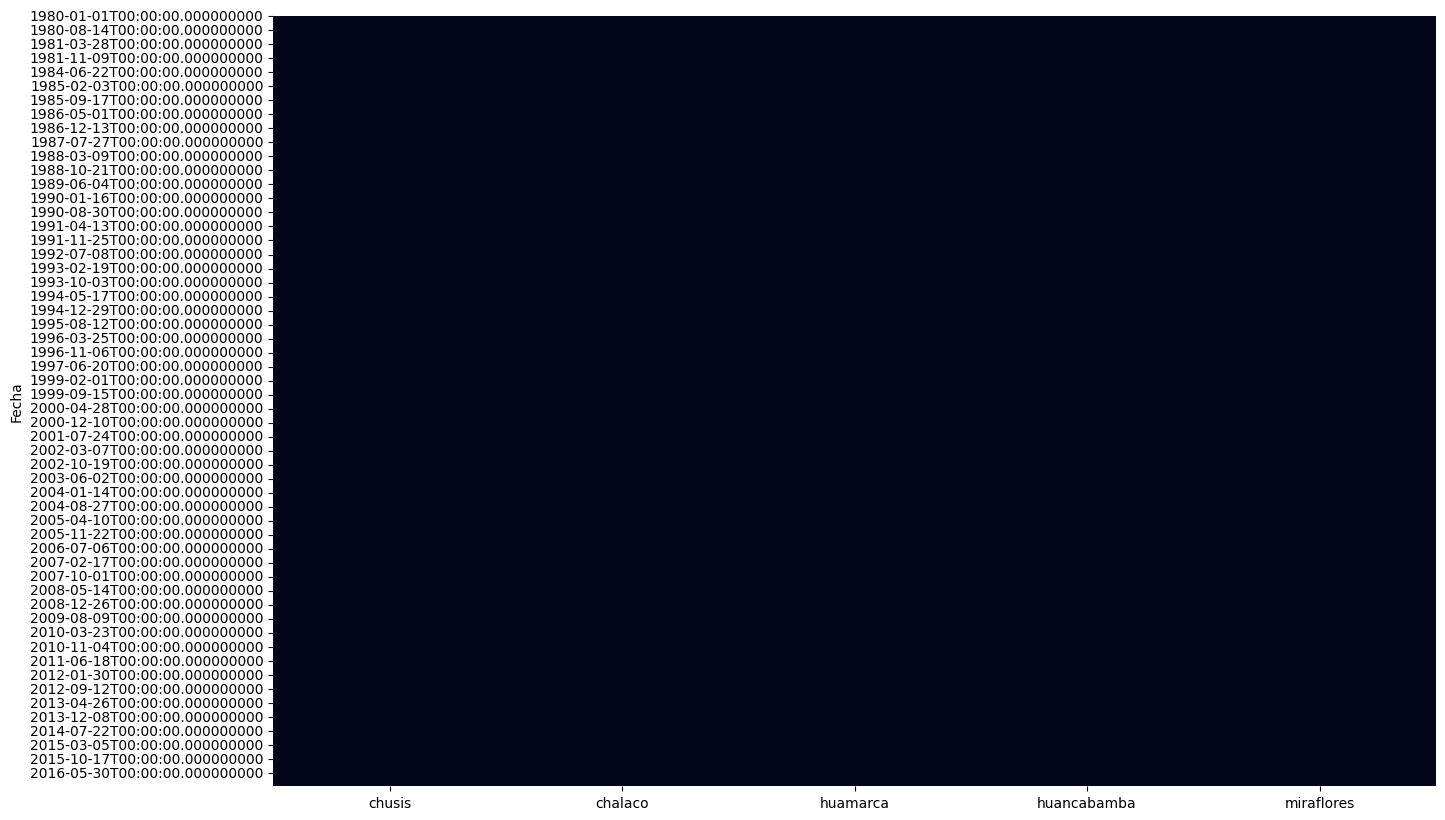

In [27]:
plt.figure(figsize=(15,10))
sns.heatmap(obs.isnull(), cbar=False)
plt.show()

# Remover años El Niño

In [ ]:
def remove_years(df, years_to_remove):
    # Convert the index to datetime if it is not already
    df.index = pd.to_datetime(df.index)
    
    # Filter out the rows where the year of the index is in the years_to_remove list
    df_filtered = df[~df.year.isin(years_to_remove)]
    
    return df_filtered


# List of years to remove
years_to_remove = [1982,1983,1998,2017]

# Remove the specified years
df_cleaned = remove_years(obs, years_to_remove)

# Display the result
df_cleaned.head(10)


# Doble Masa

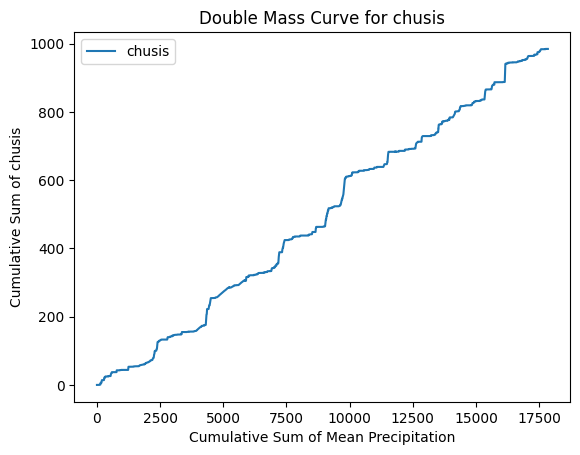

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18004\1371819708.py:32: RuntimeWarning: invalid value encountered in divide
  derivative = np.diff(cumulative_sum) / np.diff(cumulative_mean)


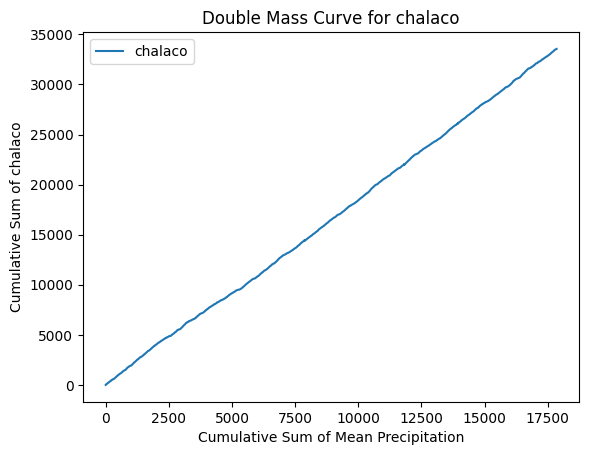

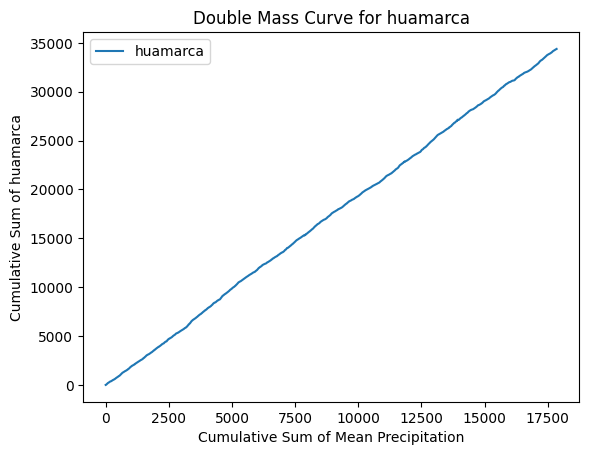

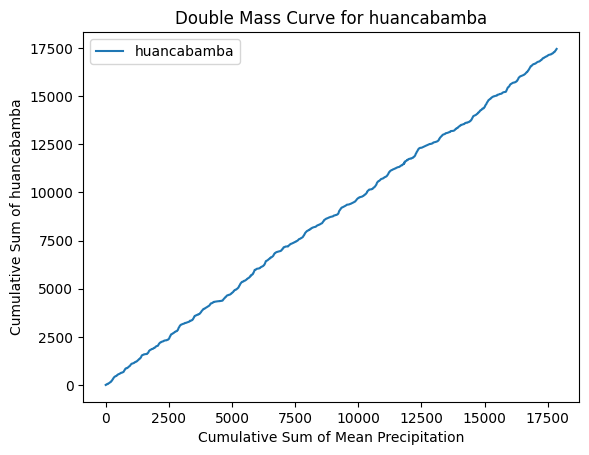

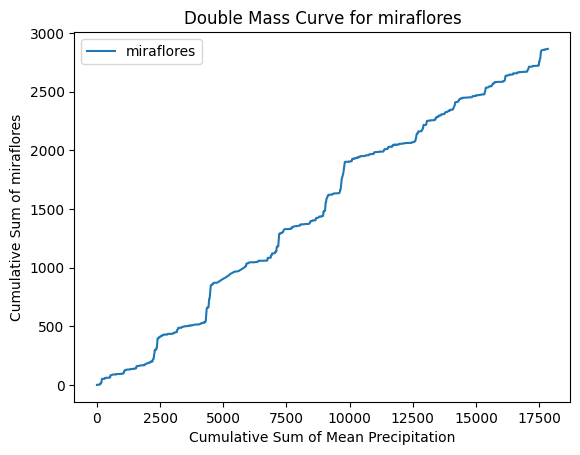

{'chusis': [], 'chalaco': [], 'huamarca': [], 'huancabamba': [], 'miraflores': []}


In [29]:
def identify_breaks_dmc(df):
    # Ensure the first column is in datetime format
    #df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
    
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_copy = df.copy()
    
    # Calculate the mean of all gauge stations and add it to the copy DataFrame
    df_copy['Mean'] = df_copy.iloc[:, 0:].mean(axis=1)
    
    # Initialize a dictionary to store results
    breaks_dict = {}
    
    # Calculate cumulative sum of the mean column
    cumulative_mean = df_copy['Mean'].cumsum()
    
    # Iterate over each gauge station, excluding the mean column
    for col in df_copy.columns[0:-1]:
        # Calculate the cumulative sums for the gauge station
        cumulative_sum = df_copy[col].cumsum()
        
        # Plot the double mass curve for visual inspection (optional)
        plt.figure()
        plt.plot(cumulative_mean, cumulative_sum, label=col)
        plt.xlabel('Cumulative Sum of Mean Precipitation')
        plt.ylabel(f'Cumulative Sum of {col}')
        plt.title(f'Double Mass Curve for {col}')
        plt.legend()
        plt.show()
        
        # Identify breaks in the slope using changes in the derivative
        derivative = np.diff(cumulative_sum) / np.diff(cumulative_mean)
        breaks = np.where(np.abs(np.diff(derivative)) > np.mean(np.abs(np.diff(derivative))) + 2 * np.std(np.abs(np.diff(derivative))))[0]
        
        # Store the indices of the breaks in the dictionary
        breaks_dict[col] = list(breaks + 1)  # +1 to account for the shift caused by np.diff
    
    return breaks_dict

# Example usage:
# Assuming df_cleaned is the filtered DataFrame from the previous step
#breaks = identify_breaks_dmc(df_cleaned)
breaks = identify_breaks_dmc(obs)

# Display the result
print(breaks)

# Análisis anual de puntos de cambio con 3 test estadísticos

Para realizar los test se anaualizo los datos de la BD

| Mostrar Tabla     |
|    Resumida       |
+-------------------+

| Display Summary   |
|     Table         |
+-------------------+


In [ ]:
df_year = df_cleaned.groupby(df_cleaned.index.to_period('Y')).sum()
def perform_tests_summary(df_cleaned):
    stations = df_cleaned.columns[0:]  # Exclude the date column
    summary_data = []

    for station in stations:
        pettitt_res = hg.pettitt_test(df_cleaned[[station]], alpha=0.01)
        snht_res = hg.snht_test(df_cleaned[[station]], sim=100000)
        buishand_res = hg.buishand_u_test(df_cleaned[[station]])

        summary_data.append({
            'Station': station,
            'Pettitt_CP': pettitt_res.cp,
            'Pettitt_Hypothesis': pettitt_res.h,
            'Pettitt_Mean_Pre': pettitt_res.avg.mu1,
            'Pettitt_Mean_Post': pettitt_res.avg.mu2,
            'SNHT_CP': snht_res.cp,
            'SNHT_Hypothesis': snht_res.h,
            'SNHT_Mean_Pre': snht_res.avg.mu1,
            'SNHT_Mean_Post': snht_res.avg.mu2,
            'Buishand_CP': buishand_res.cp,
            'Buishand_Hypothesis': buishand_res.h,
            'Buishand_Mean_Pre': buishand_res.avg.mu1,
            'Buishand_Mean_Post': buishand_res.avg.mu2
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df

# Assuming df_cleaned is already defined and contains your cleaned data
summary_table = perform_tests_summary(df_year)

# Display the summary table
print(summary_table)

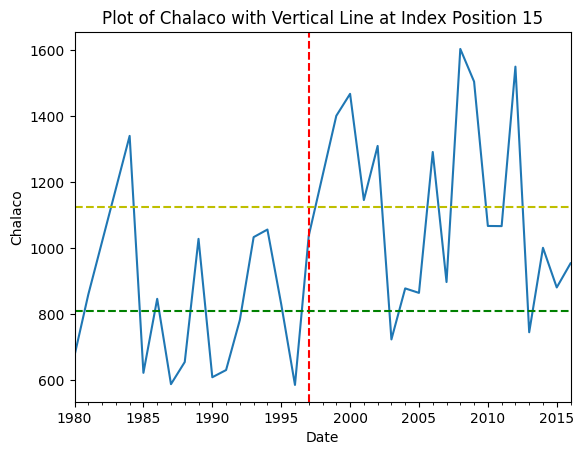

In [18]:
# Plot the 'chalaco' column
df_year['chalaco'].plot()
# Get the index position 15
index_position_15 = df_year.index[15]

# Plot a vertical line at index position 15
plt.axvline(x=index_position_15, color='r', linestyle='--')
plt.axhline(y=808.865333, color='g', linestyle='--')
plt.axhline(y=1125.048947, color='y', linestyle='--')


# Show the plot
plt.title('Plot of Chalaco with Vertical Line at Index Position 15')
plt.xlabel('Date')
plt.ylabel('Chalaco')
plt.show()

Period('1997', 'Y-DEC')